# Traffic Sign Recognition Using GTSRB

### Importing Libraries

In [1]:
import numpy as np
import os
import datetime
import PIL
import PIL.Image
import tensorflow as tf
import pandas as pd
import cv2
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical

In [2]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print(f"Found {len(tf.config.list_physical_devices('GPU'))} GPU at: {device_name}")

Found 1 GPU at: /device:GPU:0


2021-11-28 09:07:14.586939: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-28 09:07:14.628530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 09:07:14.724664: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 09:07:14.725585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

### Setting the path to the dataset

In [3]:
data_dir = "../input/gtsrb-german-traffic-sign"  #./../kaggle/
train_path = f"{data_dir}/Train"
test_path = f"{data_dir}/"

print(os.listdir(data_dir))

['Meta', 'meta', 'Meta.csv', 'Train.csv', 'Test.csv', 'Test', 'test', 'Train', 'train']


### Defining Initial Constants

In [4]:
img_height = 48
img_width = 48
img_size = (img_height, img_width)

num_categories = len(os.listdir(train_path))
print("Number of categories: ", num_categories)

Number of categories:  43


### Exploring the Categories

In [5]:
# Load the csv file to grab the names of the traffic signs
sign_names_df = pd.read_csv("../input/gtsrb-models-idatt-2502/sign_names.csv", index_col='ClassId')

def get_sign_name_from_class_id(class_id, char_limit = -1):
    '''
    Get the name of the traffic sign given its class id
    Potentially limit very long sign names to be able to display them nicely
    '''
    name = sign_names_df.iloc[class_id]['SignName']
    if char_limit > 0:
        name = name[:char_limit]
    return name

In [6]:
sign_names_df

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


### Creating the dataset

##### About the dataset
We chose to split the test folder into 80% for testing and 20% for validation


In [7]:
def load_data(data_dir):
    images = list()
    labels = list()
    for category in range(num_categories):
        categories = os.path.join(data_dir, str(category))
        for img in os.listdir(categories):
            img = load_img(os.path.join(categories, img), target_size=img_size)
            image = img_to_array(img)
            images.append(image)
            labels.append(category)
    
    return images, labels

In [8]:
images, classes = load_data(train_path)

train_labels = np.array(classes)
# One hot encoding the labels
labels = to_categorical(classes)

# Splitting the dataset into training and test set
x_train, x_val, y_train, y_val = train_test_split(np.array(images), labels, test_size=.2)
print(f"Using {len(x_train)} images for training")
print(f"Using {len(x_val)} images for validation")

validation_ds = (x_val, y_val)

Using 31367 images for training
Using 7842 images for validation


### Data Exploration

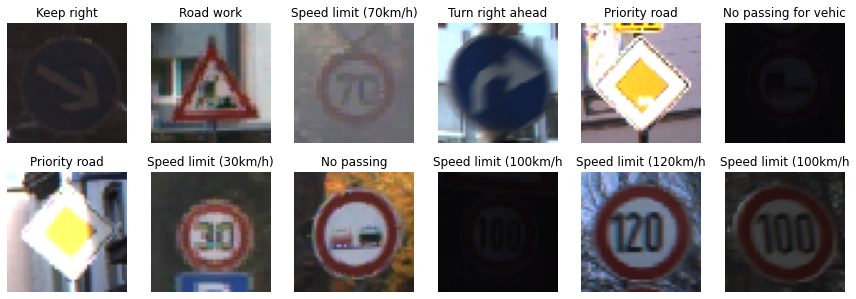

In [9]:
import matplotlib.pyplot as plt
import random
from matplotlib import pyplot

def plot_examples(x_ds, y_ds, size=12):
    plt.figure(figsize=(15, 16))
    for i in range(size):
        plt.subplot(6,6,i+1)
        index = np.random.randint(0, len(x_ds), 1)[0]
        plt.imshow(np.array(x_ds[index]).astype("uint8"))
        plt.title(get_sign_name_from_class_id(y_ds[index].argmax(), char_limit=20))
        plt.axis("off")

plot_examples(x_train, y_train)

#### Class Distributions Histogram

In [10]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(get_sign_name_from_class_id(int(folder), char_limit=20))

In [11]:
def count_images_in_classes(ds):
    dct = {}
    for i in ds:
        i = i.argmax()
        if i in dct:
            dct[i] += 1
        else:
            dct[i] = 1
    return dict(sorted(dct.items(), key=lambda item: item[0])) # 1

def distribution_diagram(dct, fig_name="distribution_diagram.png"):
    plt.figure(figsize=(21,10)) 
    plt.bar(range(len(dct)), list(dct.values()), align='center')
    plt.xticks(range(len(dct)), list(map(get_sign_name_from_class_id, (dct.keys()))), rotation='vertical')
    plt.savefig(fig_name)
    plt.show()

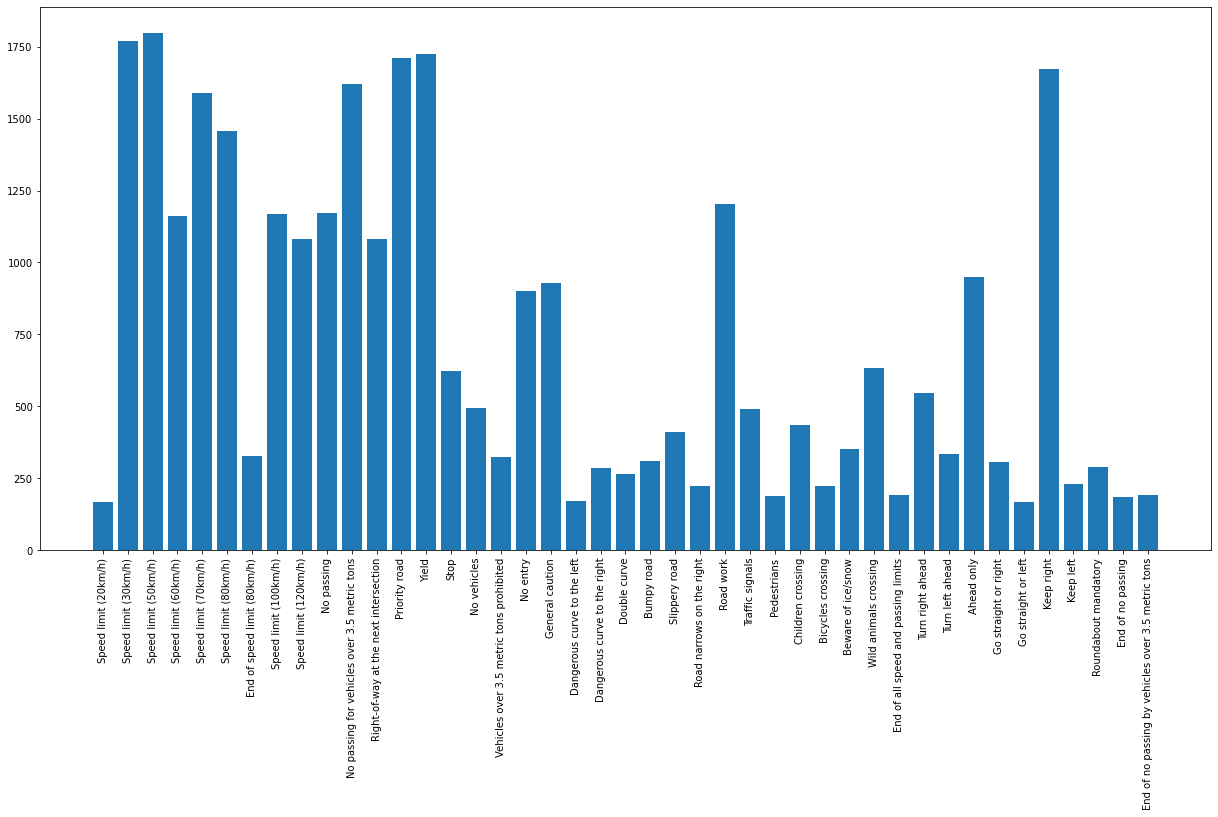

In [12]:
x = count_images_in_classes(y_train)
distribution_diagram(x, fig_name="distribution_diagram_unbalanced.png")

### Data Augmentation

Exploration of the dataset revealed a few concerns. The first being that class distribution is skewed and unbalanced which can lead to bias during the training process. Secondly, there is insufficient amounts of samples for the model to learn with high generalization and robustness caused by natural distortions occuring in the field.

The following use of data augmentation is an attempt to resolve both these issues by producing more data with distortions which are to be expected from real data, for instance rotations, translations and projections. 

In [13]:
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform
from imgaug import augmenters as iaa
import cv2


def augment_imgs(imgs, p):
    """
    Performs a set of augmentations with with a probability p
    """
    shear = np.random.uniform(low=0, high=5.7)

    augs =  iaa.SomeOf((2, 4),
          [
              iaa.Crop(px=(0, 4)), # crop images from each side by 0 to 4px (randomly chosen)
              iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}),
              iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
              iaa.Affine(rotate=(-10, 10)), # rotate by -15 to +15 degrees)
              iaa.Affine(shear=(-shear, shear)), # shear by -10 to +10 degrees
          ])
    
    seq = iaa.Sequential([iaa.Sometimes(p, augs)])
    res = seq.augment_images(imgs)
    return res

def augmentation(imgs, lbls, min_images_in_class=500):
    classes = count_images_in_classes(lbls)
    
    for i in range(len(classes)):        
        if (classes[i] < min_images_in_class):
            
            # Number of samples to be added
            add_num = min_images_in_class - classes[i]
            imgs_for_augm = []
            lbls_for_augm = []

            for j in range(add_num):
                indices = np.where((y_train.argmax(axis=1) == i) == True)[0]
                im_index = random.choice(indices)
                
                imgs_for_augm.append(imgs[im_index]) 
                lbls_for_augm.append(lbls[im_index])
                        
            augmented_class = augment_imgs(imgs_for_augm, 1)
            augmented_class_np = np.array(augmented_class)
            augmented_lbls_np = np.array(lbls_for_augm)

            imgs = np.concatenate((imgs, augmented_class_np), axis=0)
            lbls = np.concatenate((lbls, augmented_lbls_np), axis=0)
    
    return imgs, lbls

In [14]:
x_train_aug, y_train_aug = augmentation(x_train, y_train, min_images_in_class=500)

In [15]:
print(f"Using {len(x_train_aug)} images for training after data augmentation")

Using 36287 images for training after data augmentation


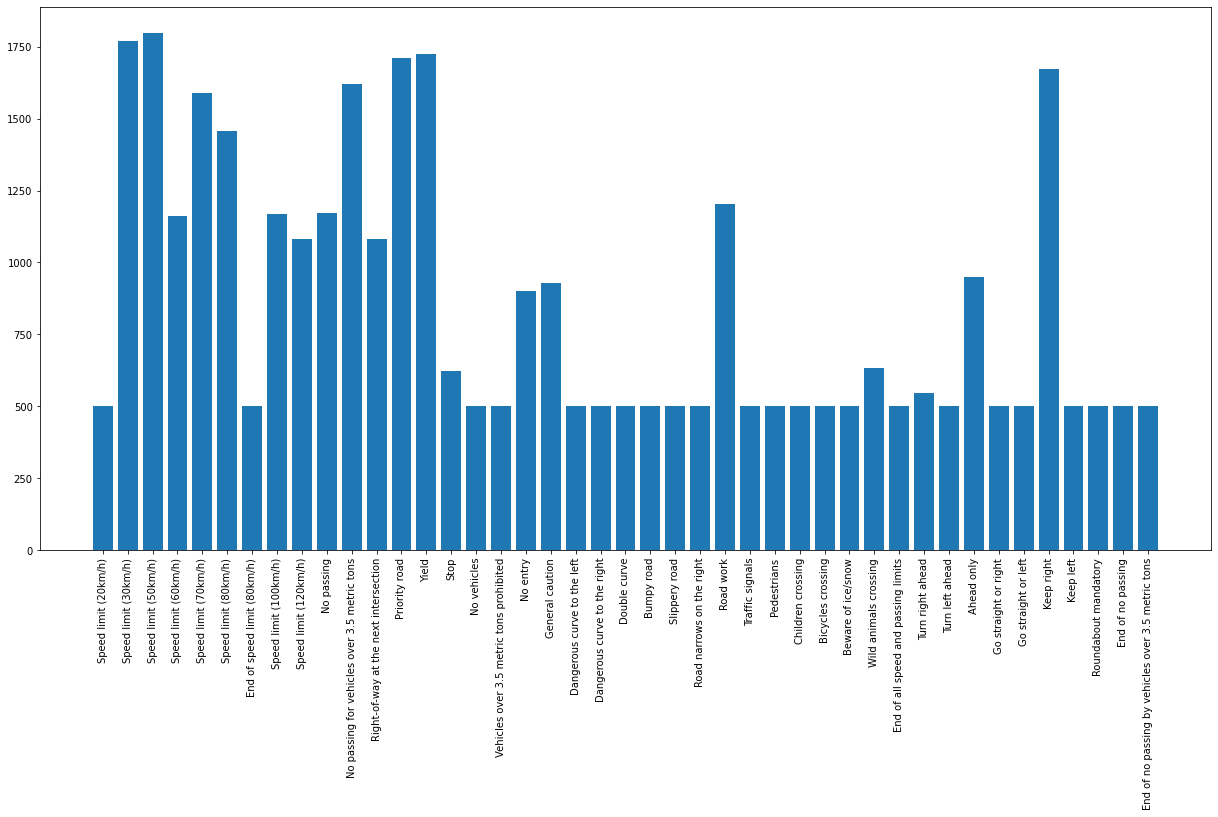

In [16]:
x = count_images_in_classes(y_train_aug)
distribution_diagram(x, fig_name="distribution_diagram_balanced.png")

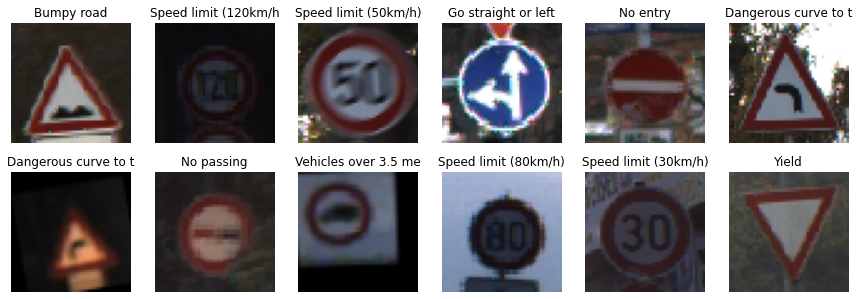

In [17]:
plot_examples(x_train_aug, y_train_aug)

### Creating the model

2021-11-28 09:12:04.848154: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 09:12:04.849160: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 09:12:04.849907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 09:12:04.850711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 09:12:04.851396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv_1_3x3 (Conv2D)             (None, 48, 48, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 48, 48, 32)   128         conv_1_3x3[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 48, 48, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

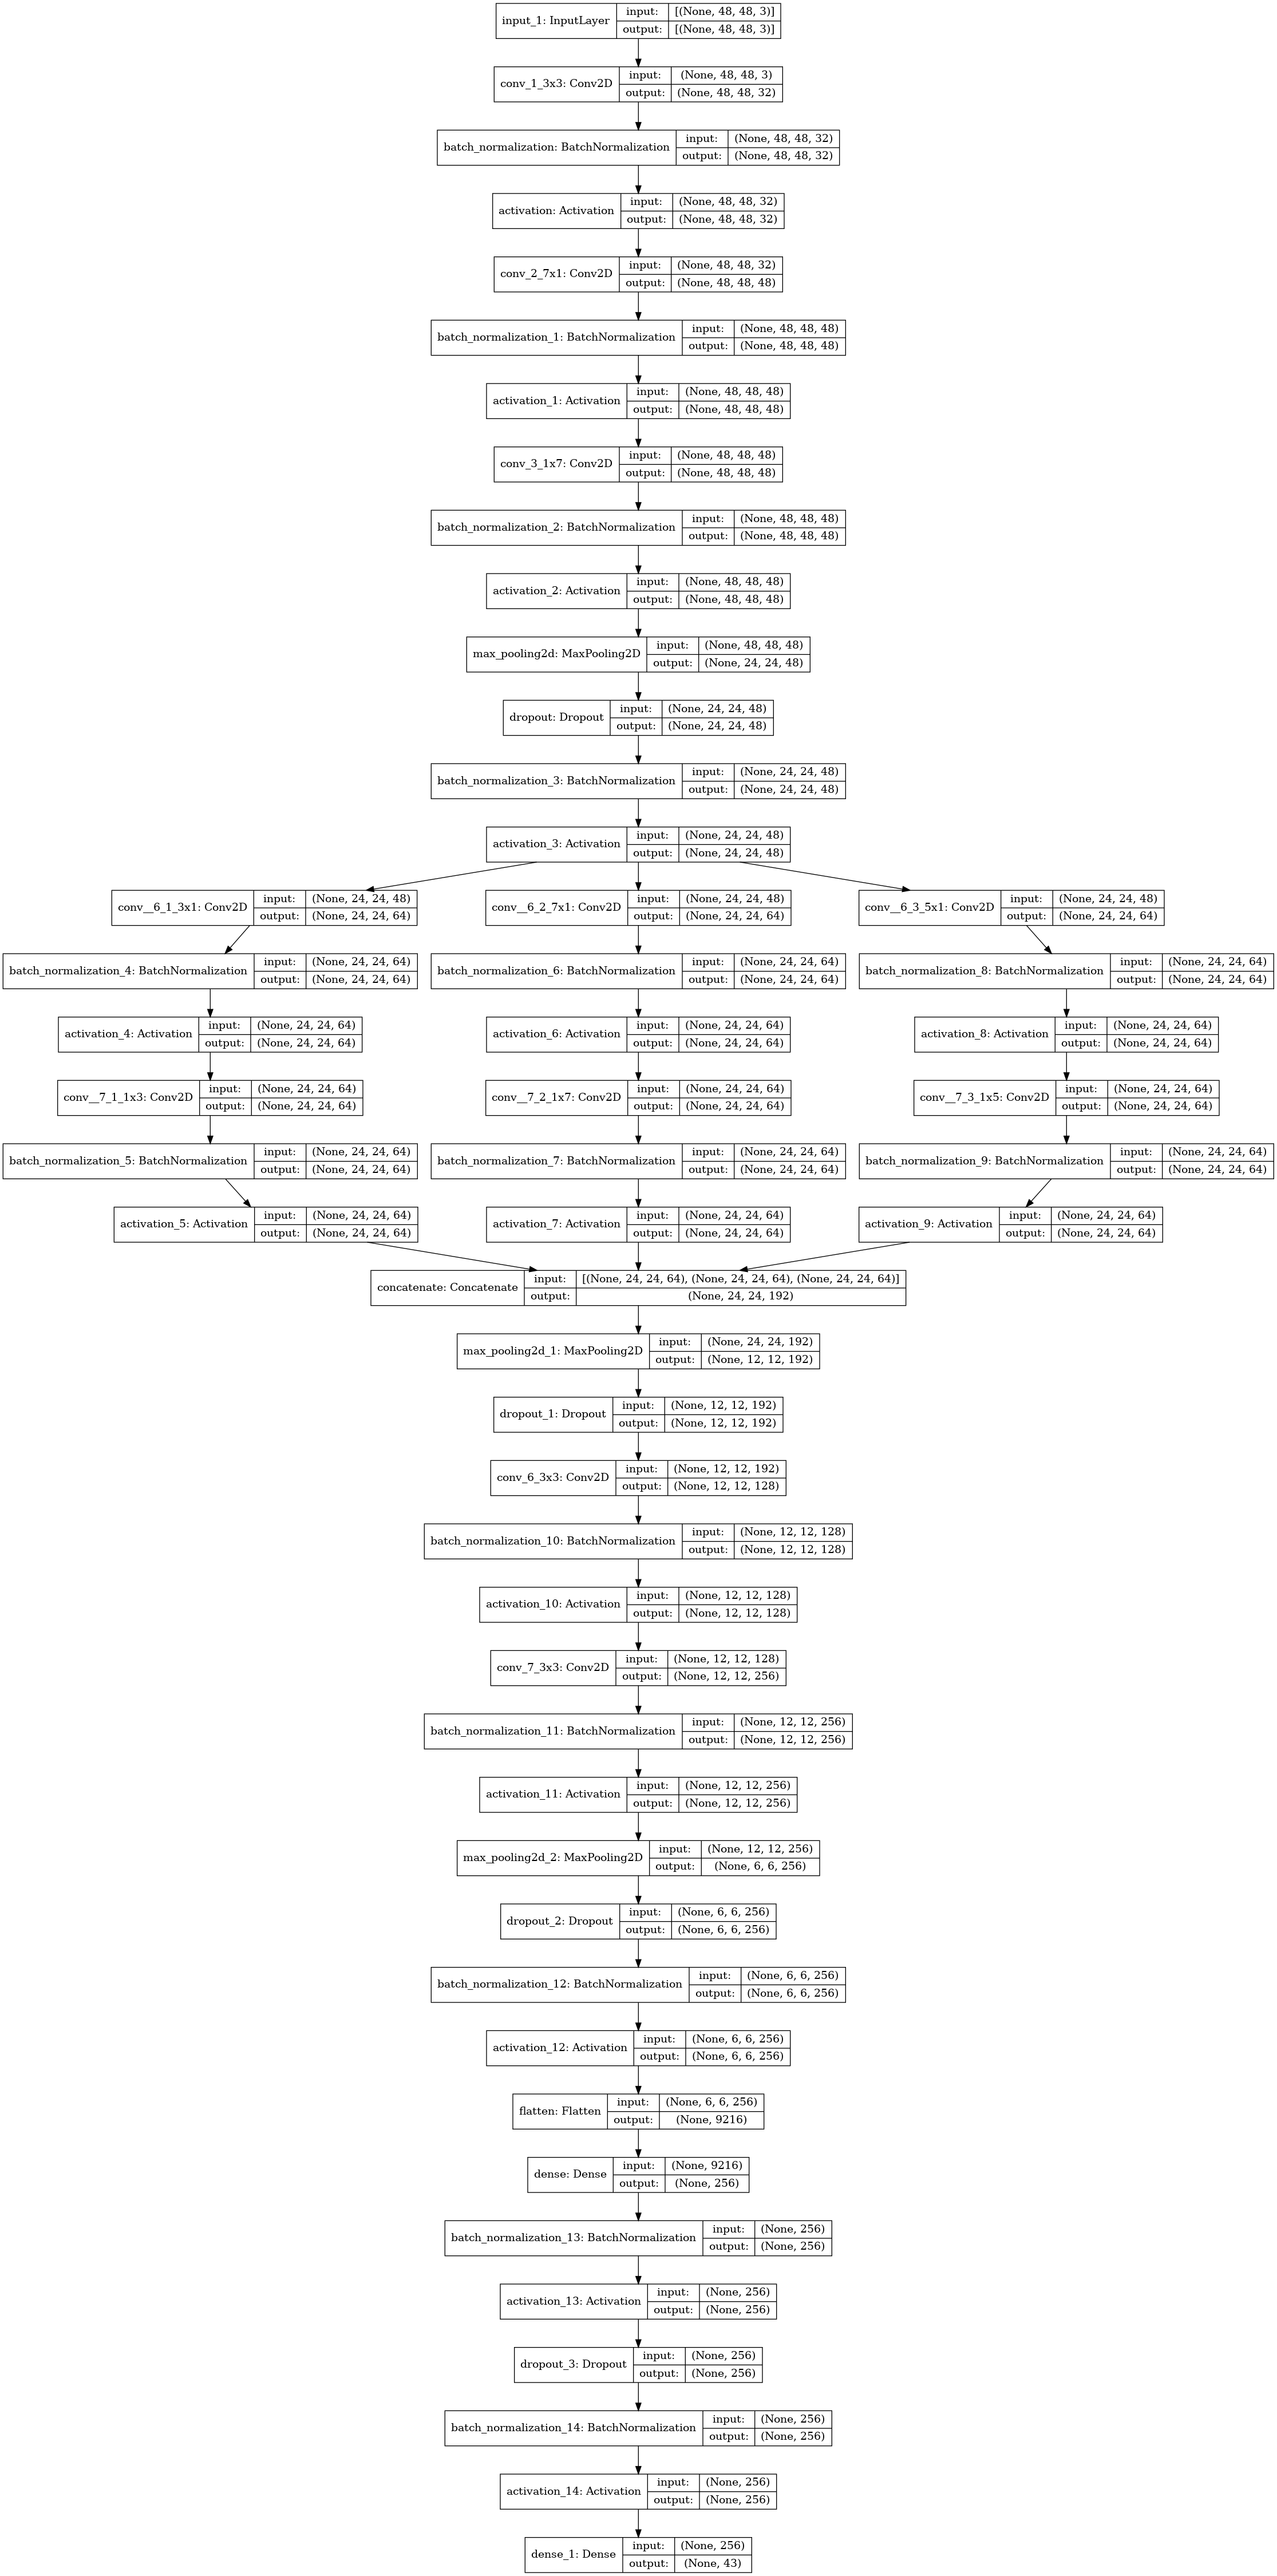

In [18]:
from tensorflow.keras import layers
from keras.models import Model
from tensorflow.keras.utils import plot_model


def conv2D_bn_relu(x, filters, kernel_size, strides=(1, 1), padding='same', kernel_initializer='glorot_uniform', name=None):
    """2D convolution layer followed by batch normalization and ReLU activation."""    
    x = layers.Conv2D(filters=filters, 
                      kernel_size=kernel_size, 
                      strides=strides, 
                      padding=padding, 
                      kernel_initializer=kernel_initializer,
                      name=name,
                      use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    return layers.Activation('relu')(x)


def inception_module(x, filters=None, kernel_initializer='glorot_uniform'):
    """Variant of Inception module as described in Figure 6 of "Going deeper with convolutions" (Szegedy, et al. 2014).
    
    # Arguments
        :param x - 4D tensor with shape: `(batch, rows, columns, channels)`.
        :param filters - Number of output filters for the module.
        :param kernel_initializer: Weight initializer for all convolutional layers in module.
    """
        
    b1 = conv2D_bn_relu(x, 
                         filters=filters, 
                         kernel_size=(3, 1), 
                         strides=1, 
                         padding='same', 
                         name='conv__6_1_3x1',
                         kernel_initializer=kernel_initializer)
    
    b1 = conv2D_bn_relu(b1, 
                         filters=filters, 
                         kernel_size=(1, 3), 
                         strides=1, 
                         padding='same', 
                         name='conv__7_1_1x3',
                         kernel_initializer=kernel_initializer)

    b2 = conv2D_bn_relu(x, 
                         filters=filters, 
                         kernel_size=(7, 1),
                         strides=1, 
                         padding='same', 
                         name='conv__6_2_7x1',
                         kernel_initializer=kernel_initializer)
    
    b2 = conv2D_bn_relu(b2, 
                         filters=filters, 
                         kernel_size=(1, 7), 
                         strides=1, 
                         padding='same', 
                         name='conv__7_2_1x7',
                         kernel_initializer=kernel_initializer)
    
    
    b3 = conv2D_bn_relu(x, 
                         filters=filters, 
                         kernel_size=(5, 1), 
                         strides=1, 
                         padding='same', 
                         name='conv__6_3_5x1',
                         kernel_initializer=kernel_initializer)
    
    b3 = conv2D_bn_relu(b3, 
                         filters, 
                         kernel_size=(1, 5), 
                         strides=1, 
                         padding='same', 
                         name='conv__7_3_1x5',
                         kernel_initializer=kernel_initializer)
    
    return layers.concatenate([b1, b2, b3])


inputs = layers.Input(shape=(48, 48, 3))

x = conv2D_bn_relu(inputs,
                   filters=32,
                   kernel_size=(3, 3),
                   strides=1,
                   padding='same',
                   name='conv_1_3x3')

x = conv2D_bn_relu(x,
                   filters=48,
                   kernel_size=(7, 1),
                   strides=1,
                   padding='same',
                   name='conv_2_7x1')           

x = conv2D_bn_relu(x,
                   filters=48,
                   kernel_size=(1, 7),
                   strides=1,
                   padding='same',
                   name='conv_3_1x7')

x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = layers.Dropout(rate=.2)(x)
x = layers.BatchNormalization()(x) 
x = layers.Activation('relu')(x)  

x = inception_module(x, filters=64) 

x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = layers.Dropout(rate=.2)(x)

x = conv2D_bn_relu(x,
                   filters=128,
                   kernel_size=(3, 3),
                   strides=1,
                   padding='same',
                   name='conv_6_3x3')

x = conv2D_bn_relu(x,
                   filters=256,
                   kernel_size=(3, 3),
                   strides=1,
                   padding='same',
                   name='conv_7_3x3')

x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = layers.Dropout(rate=.3)(x)
x = layers.BatchNormalization()(x) 
x = layers.Activation('relu')(x) 

x = layers.Flatten()(x)

x = layers.Dense(units=256, activation='relu')(x)
x = layers.BatchNormalization()(x) 
x = layers.Activation('relu')(x) 

x = layers.Dropout(rate=.4)(x)
x = layers.BatchNormalization()(x) 
x = layers.Activation('relu')(x) 

x = layers.Dense(units=num_categories, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)

model.summary()
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

### Compiling the Model

In [19]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Define Model Checkpoints to Save the Best Results for Later Use

In [20]:
checkpoint_filepath = '/tmp/checkpoint'

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

### Fitting the Model

In [21]:
epochs = 200
batch_size = 60

history = model.fit(
    x_train_aug,
    y_train_aug,
    validation_data=validation_ds,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[model_checkpoint_callback]
)

2021-11-28 09:12:07.741364: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1003262976 exceeds 10% of free system memory.
2021-11-28 09:12:08.919979: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1003262976 exceeds 10% of free system memory.
2021-11-28 09:12:09.677777: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2021-11-28 09:12:12.012254: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


605/605 [==============================] - 25s 28ms/step - loss: 1.3750 - accuracy: 0.6403 - val_loss: 0.3397 - val_accuracy: 0.9550
Epoch 2/200
605/605 [==============================] - 16s 27ms/step - loss: 0.1664 - accuracy: 0.9599 - val_loss: 0.0935 - val_accuracy: 0.9917
Epoch 3/200
605/605 [==============================] - 16s 27ms/step - loss: 0.0792 - accuracy: 0.9803 - val_loss: 0.1249 - val_accuracy: 0.9904
Epoch 4/200
605/605 [==============================] - 16s 27ms/step - loss: 0.0590 - accuracy: 0.9844 - val_loss: 0.1179 - val_accuracy: 0.9938
Epoch 5/200
605/605 [==============================] - 16s 27ms/step - loss: 0.0370 - accuracy: 0.9900 - val_loss: 0.1207 - val_accuracy: 0.9830
Epoch 6/200
605/605 [==============================] - 16s 27ms/step - loss: 0.0296 - accuracy: 0.9921 - val_loss: 0.0667 - val_accuracy: 0.9931
Epoch 7/200
605/605 [==============================] - 16s 27ms/step - loss: 0.0207 - accuracy: 0.9950 - val_loss: 0.0470 - val_accuracy: 0.99

### Visualize the training

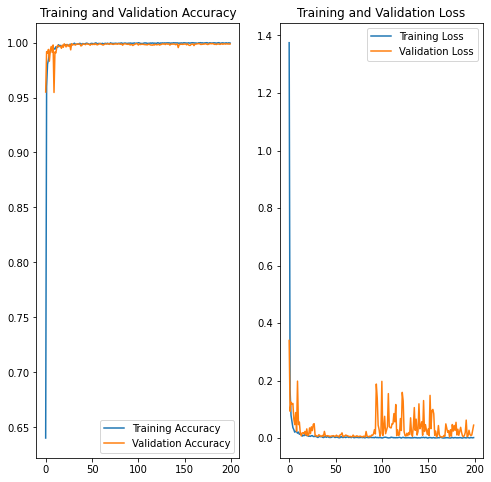

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig("training.png")
plt.show()

### Evaluating the model

In [23]:
import pandas as pd

y_test = pd.read_csv(test_path + 'Test.csv')
test_labels = y_test["ClassId"].values
test_images = y_test["Path"].values

test_labels = np.array(test_labels)

output = list()
for img in test_images:
    image = load_img(os.path.join(test_path, img), target_size=img_size)
    output.append(np.array(image))

x_test = np.array(output)


In [24]:
prediction = model.predict(x_test, verbose=1)

# Convert tests labels in single-digits instead of one-hot encoding
Y_pred = np.argmax(prediction,axis=1)

395/395 [==============================] - 2s 4ms/step



#### Predicting the Trained Model with the Test Data

In [25]:
from sklearn.metrics import accuracy_score

#Accuracy with the test data
print('Test data accuracy: ', accuracy_score(test_labels, Y_pred) * 100)  

Test data accuracy:  98.96278701504355


In [26]:
# The model weights (that are considered the best) are loaded into the model. 
model.load_weights(checkpoint_filepath)

prediction = model.predict(x_test, verbose=1)

# Convert tests labels in single-digits instead of one-hot encoding
Y_pred = np.argmax(prediction,axis=1)

print('Test data accuracy: ', accuracy_score(test_labels, Y_pred) * 100)  

395/395 [==============================] - 1s 3ms/step
Test data accuracy:  99.01029295328583


### Perform some visual testing

This image most likely belongs to Speed limit (120km/h) with a 5.73% confidence.


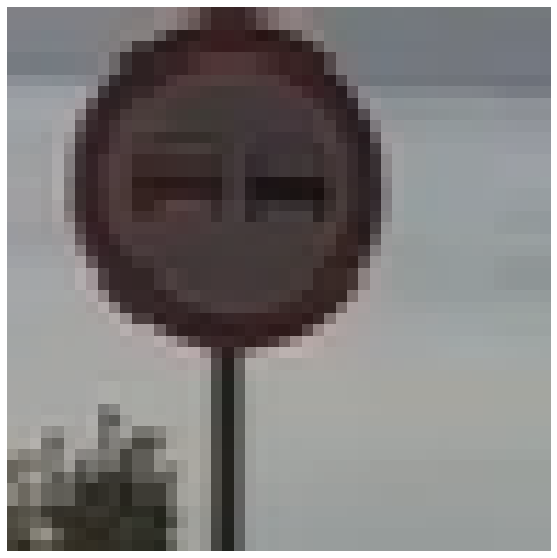

In [27]:
img = tf.keras.preprocessing.image.load_img("../input/gtsrb-models-idatt-2502/no-passing.png", target_size=img_size)
input_arr = tf.keras.preprocessing.image.img_to_array(img) 
input_arr = np.array([input_arr])  # Convert single image to a batch.

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")

scores = model.predict(input_arr)
score = tf.nn.softmax(scores)
prediction = np.argmax(scores)

label = get_sign_name_from_class_id(prediction, char_limit=30)

print(
    "This image most likely belongs to {} with a {:.2f}% confidence."
    .format(label, 100 * np.max(score))
)

### Testing the Predictions on Images from Meta/

In [28]:
show_images = False

meta_test = pd.read_csv(f"{data_dir}/Meta.csv")
img_paths = meta_test["Path"].values
img_labels = meta_test["ClassId"].values

images = list()
labels = list()
output = list()
for image_path in img_paths:
    full_path = f"{data_dir}/{image_path}"
    image = load_img(full_path, target_size=img_size)
    output.append(np.array(image))
    
x_meta = np.array(output)
    
prediction = model.predict(x_meta, verbose=1)
score = tf.nn.softmax(prediction)

for i, pred in enumerate(prediction):
    class_id = pred.argmax()
    label = get_sign_name_from_class_id(class_id=class_id, char_limit=30)
    
    if class_id == img_labels[i]:
        print("Correctly classified image: ", img_paths[i], " as class ", label, '\n')
    else:
        print("Incorrectly classified image: ", img_paths[i], " as class ", label, '\n')
        
    if show_images: 
        plt.figure(figsize=(4, 4))
        plt.imshow(output[i])
        plt.axis("off")
        plt.show()


2/2 [==============================] - 0s 57ms/step
Correctly classified image:  Meta/27.png  as class  Pedestrians 

Correctly classified image:  Meta/0.png  as class  Speed limit (20km/h) 

Incorrectly classified image:  Meta/1.png  as class  Roundabout mandatory 

Correctly classified image:  Meta/10.png  as class  No passing for vehicles over 3 

Correctly classified image:  Meta/11.png  as class  Right-of-way at the next inter 

Correctly classified image:  Meta/12.png  as class  Priority road 

Correctly classified image:  Meta/13.png  as class  Yield 

Correctly classified image:  Meta/14.png  as class  Stop 

Correctly classified image:  Meta/15.png  as class  No vehicles 

Correctly classified image:  Meta/16.png  as class  Vehicles over 3.5 metric tons  

Correctly classified image:  Meta/17.png  as class  No entry 

Correctly classified image:  Meta/18.png  as class  General caution 

Correctly classified image:  Meta/19.png  as class  Dangerous curve to the left 

Incorrect

In [29]:
# Convert tests labels in single-digits instead of one-hot encoding
Y_pred = np.argmax(prediction,axis=1)

print('Meta data accuracy: ', accuracy_score(img_labels, Y_pred) * 100)

Meta data accuracy:  72.09302325581395


### Save the Model for Later Use

In [30]:
import tensorflow as tf
from tensorflow.keras.models import save_model

save_model(model, 'models/gtsrb-final.h5')